This experiment builds on the experiment for Figures 4 & 5 in the following paper:

Feydy, J., Séjourné, T., Vialard, F. X., Amari, S. I., Trouvé, A., & Peyré, G. (2019, April). Interpolating between optimal transport and MMD using sinkhorn divergences. In The 22nd International Conference on Artificial Intelligence and Statistics (pp. 2681-2690). PMLR.

Note that this experiment does not apply an affine (much less location-scale) transformation. Rather, it is a non-parametric data fitting problem where the source datapoints themselves are the parameters that are optimized.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

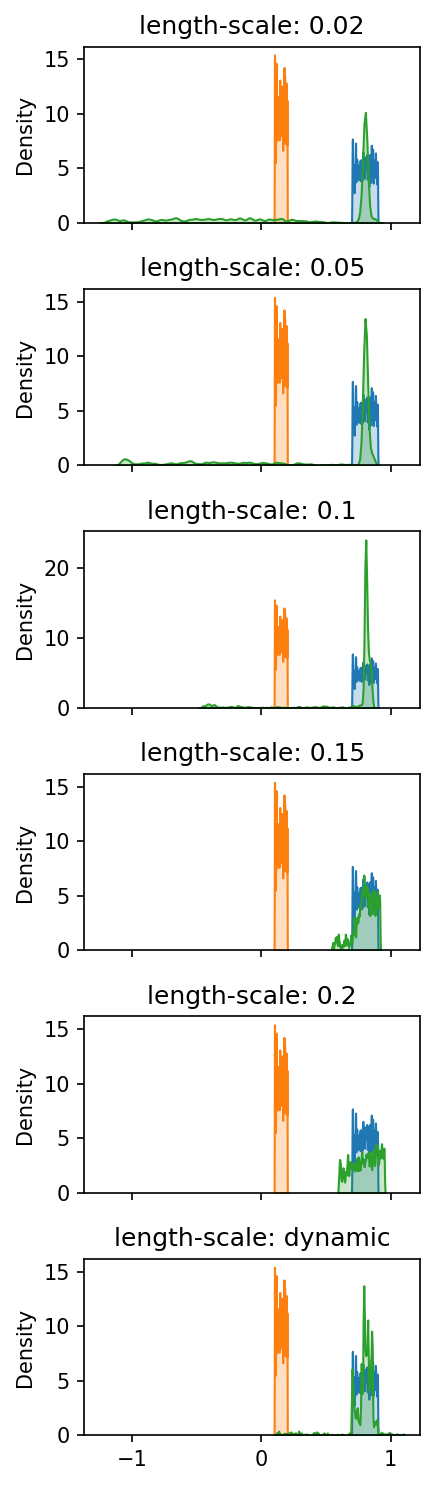

In [2]:
def mmd_adapt_points(X_S, X_T, length_scale):
    
    T = torch.from_numpy(X_T)
    S = torch.from_numpy(X_S)
    adaptedS = torch.tensor(X_S, requires_grad=True)
    adaptedSz = torch.zeros(N, 1)
    alpha = 1e-6
    beta = 0.9
    n_epochs = 100
    
    for epoch in range(n_epochs):
        if length_scale == "dynamic":
            lscale = torch.mean((T - adaptedS) ** 2).detach().numpy()
        else:
            lscale = length_scale
        obj = torch.tensor(0.0, requires_grad=True)
        obj = obj - 2 * torch.sum(
            torch.exp(
                -1 / (2 * lscale)
                * (
                    (T @ T.T).diag().unsqueeze(1)
                    - 2 * T @ adaptedS.T
                    + (adaptedS @ adaptedS.T).diag().unsqueeze(0)
                )
            )
        )
        obj = obj + torch.sum(
            torch.exp(
                -1 / (2 * lscale)
                * (
                    (adaptedS @ adaptedS.T).diag().unsqueeze(1)
                    - 2 * adaptedS @ adaptedS.T
                    + (adaptedS @ adaptedS.T).diag().unsqueeze(0)
                )
            )
        )
        obj.backward()
        with torch.no_grad():
            adaptedSz = beta * adaptedSz + adaptedS.grad
            adaptedS -= alpha * adaptedSz 
        adaptedS.grad.zero_()
    return adaptedS.detach().numpy()

N = 1000
rng = np.random.RandomState(1)
X_S = rng.uniform(0.1, 0.2, size=(N,1))
X_T = 0.5 + 2 * X_S
lscales = [0.02, 0.05, 0.1, 0.15, 0.2, "dynamic"]
fig, axes = plt.subplots(nrows=len(lscales), sharex=True, figsize=(3, 10), dpi=150)
for ix, ls in enumerate(lscales):
    X_Sadapted = mmd_adapt_points(X_S, X_T, ls)
    sns.kdeplot(X_T.ravel(), fill=True, bw_adjust=0.1, ax=axes[ix])
    sns.kdeplot(X_S.ravel(), fill=True, bw_adjust=0.1, ax=axes[ix])
    sns.kdeplot(X_Sadapted.ravel(), fill=True, bw_adjust=0.1, ax=axes[ix])
    axes[ix].set_title(f"length-scale: {ls}")
plt.tight_layout()
plt.show()
fig.savefig("mmd-dynamic.pdf", bbox_inches="tight")